# Vehicle Detection Project


### The goals / steps of this project are the following:
    
    Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    
    Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
    
    Note: for those first two steps, don't forget to normalize your features and randomize a selection for training and testing.
    
    Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
    
    Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    
    Estimate a bounding box for vehicles detected.


In [1]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from skimage.exposure import adjust_gamma
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip
%matplotlib inline
print('Loaded')

Loaded


In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

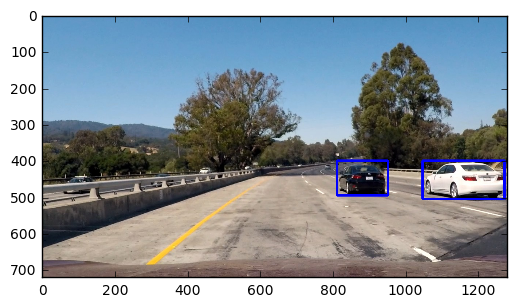

In [3]:
bboxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(mpimg.imread('test_images/test1.jpg'),bboxes=bboxes));

### Histogram of Oriented Gradients
Next, I will define a function `get_hog_features` which will be used to compute a Histogram of Oriented Gradients for a given image.  

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Load car and non-car image sets
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
print('Data loaded')

Data loaded


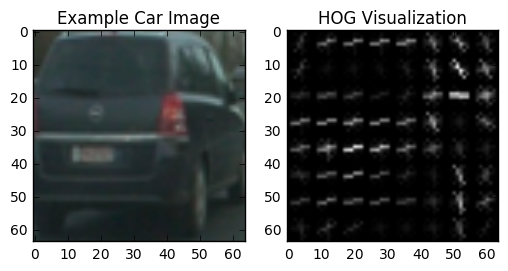

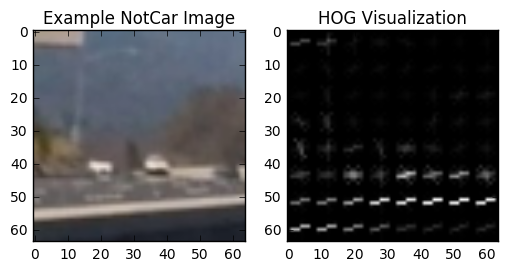

In [6]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars), size=1)
# Read in the image
image1 = mpimg.imread(cars[ind])
gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
fig1 = plt.figure()
plt.subplot(121)
plt.imshow(image1, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


image2 = mpimg.imread(notcars[ind])
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray2, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
fig2 = plt.figure()
plt.subplot(121)
plt.imshow(image2, cmap='gray')
plt.title('Example NotCar Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [7]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [8]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

28.72 Seconds to extract HOG features...


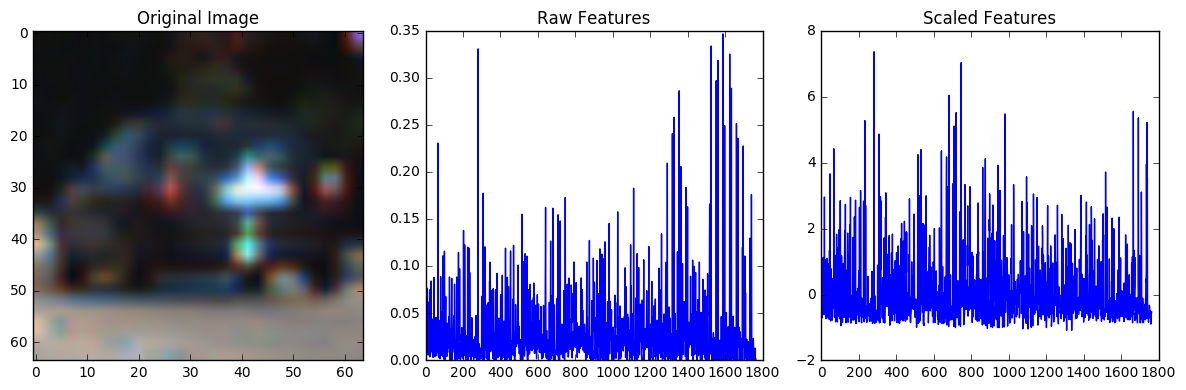

In [9]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Scaled Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [10]:
from sklearn import svm
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = svm.SVC(probability=True)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
435.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9893
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
0.05966 Seconds to predict 10 labels with SVC


In [11]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:

def pipeline(image):
    image = imread(image)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) 
    detected = []
    size = 300
    while size < 600:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 620], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((feature_image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if svc.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
        size += 10
    result = np.copy(image)
    mask = np.zeros_like(image)
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    # Find the contours
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(result, (x, y), (x+w, y+h), (0,0,255), 6)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('Image')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('Output')
    ax2.imshow(result)
print('Pipeline Created')

Pipeline Created


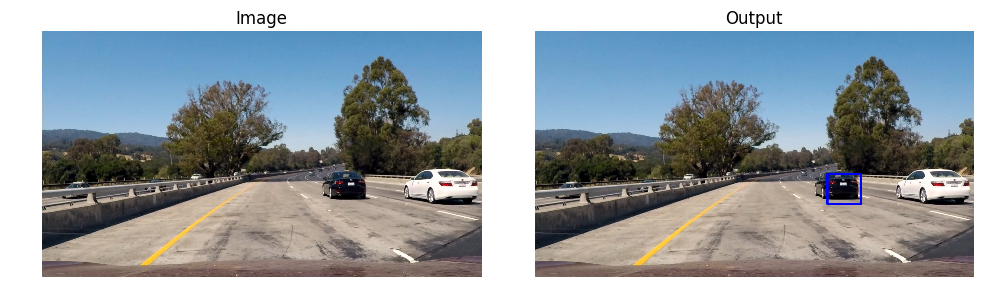

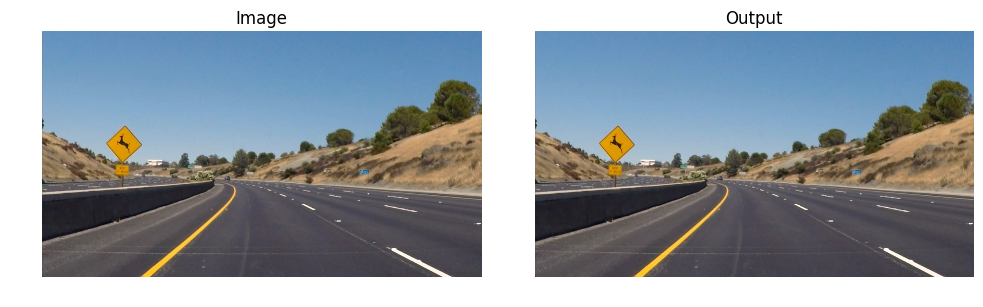

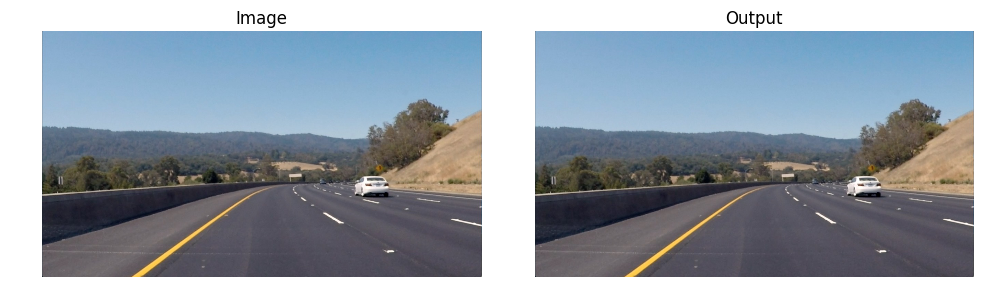

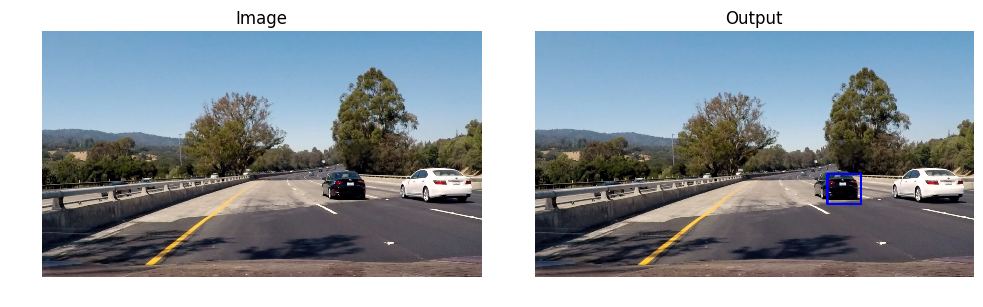

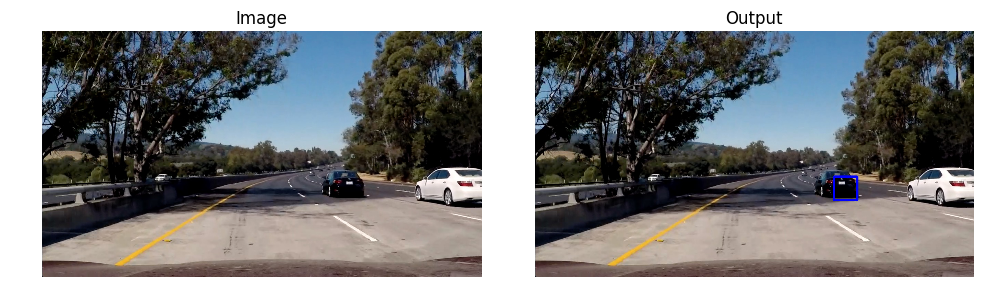

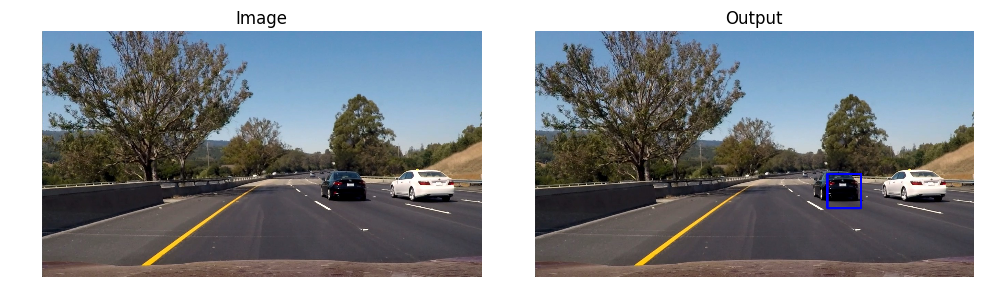

In [13]:
for image in glob.glob('test_images/*.jpg'):
    pipeline(image);

In [14]:
from collections import deque
class Contour:
    def __init__(self, n=6):
        self.count = 0
        self.recent_boxes = deque([],maxlen=n)

def video(image):
    detected = [] 
    size = 300
    count = 0
    while size < 600:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 620], 
                            xy_window=(size, size), xy_overlap=(0.6, 0.6))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if svc.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
                count += 1
        size += 10
    result = np.copy(image).astype('uint8')
    mask = np.zeros_like(image)
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    rect_list = []
    all_boxes = []
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rect_list.append([x,y,x+w,y+h])
    Boxes.recent_boxes.append(rect_list)
    combined = np.ravel(np.array(Boxes.recent_boxes))
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))
    new_boxes = []
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        i += 4
    rects,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1)
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
    Boxes.count += 1
    return result

In [15]:
Boxes = Contour()
output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(10,)
clip = clip1.fl_image(video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1010/1011 [26:07<00:01,  1.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 26min 8s
